# Validation of Exoplanet Signals using a Probabilistic Algorithm (VEPSA) Tutorial
This tutorial cracks open the black box of vespa.

If a directory is [completely prepared](#preparing-a-vespa-directory), running `vespa` consists of executing the following commands from a terminal:

    starfit --all <directory name>
    calcfpp <directory name>

The `starfit --all` command [estimates the stellar properties of the host star](#fitting-stellar-models), and `calcfpp` [computes the false positive probability](#calculating-fpp).


# Preparing a vespa directory

Running a `vespa` calculation requires creating `star.ini` and `fpp.ini` config files, as described below.


## Host star

Create a `star.ini` file containing the RA/Dec coordinates of the transit candidate host star, and any available observed properties, such as broadband photometric magnitudes, spectroscopic properties, or parallax.
All quantities are listed as `value, uncertainty`.
One of the magnitudes provided must be the band in which the transit was observed, and need not have an uncertainty (values without uncertainties will not be used in the model fitting).
Here is an example `star.ini` file:

    ra = 289.217499
    dec = 47.88446
    J = 10.523, 0.02
    H = 10.211, 0.02
    K = 10.152, 0.02
    g = 12.0428791, 0.05
    r = 11.5968652, 0.05
    i = 11.4300704, 0.05
    z = 11.393061, 0.05
    Kepler = 11.664
    Teff = 5642, 50.0
    feh = -0.27, 0.08
    logg = 4.443, 0.028

## Planet candidate

Create a text file containing the photometry of the detected candidate, detrended and phase-folded.
This file should have the following three columns in order:

  * Time from mid-transit, in units of days
  * Relative flux, normalized to unity; e.g., `flux / median(flux)`.
  * Relative flux uncertainty (also normalized)

The photometry should be limited to only those points within just a few transit durations of the transit, not the entire orbital phase.
This file may have any name, but for current purposes, let's call it `transit.txt`.

For a quick description of how to make a file like this for a new candidate, see Appendix 1 of this notebook. 

You can check to make sure that this is put together correctly by using the utilities provided in and used by `vespa` to load and visualize the candidate:

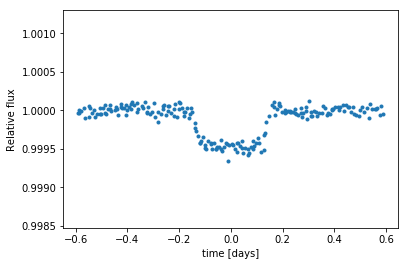

In [2]:
%matplotlib inline
from vespa import TransitSignal
trsig = TransitSignal.from_ascii('TestCase1/transit.txt')
trsig.plot()

The results of three other analyses (calculations that `vespa` does not do) must also be provided:

  - A best-fit estimate of the planet/star radius ratio.

  - An observational upper limit on the depth of a potential secondary eclipse in the light curve.
    This may be calculated by, e.g., running a transit search in the light curve at other phases but keeping the period fixed.

  - A limit on the furthest angular separation from the target star that a potential blending star might reside.
    This limit should come from pixel-level analysis of the target star photometry, establishing that the signal does not originate from a different star.
    While the tightest constraint will come from some kind of centroid or pixel-modeling effort (e.g. [Bryson et al, 2013](https://arxiv.org/pdf/1303.0052.pdf)), it should also be sufficient to test the depth of the signal as a function of aperture size, to see whether the measured depth is aperture-dependent (that is, if the signal is caused by a small amount of flux from a bright eclipsing binary many pixels away from the target, then the signal will be deeper with larger apertures.)
    A good example of what can happen if this analysis is not done carefully is with EPIC210400868 from [Cabrera et al., 2017](https://arxiv.org/pdf/1707.08007.pdf).

All of this information gets summarized in another config file: `fpp.ini`, as follows:

    name = K00087.01
    ra = 289.217499
    dec = 47.88446
    period = 289.864456     # Orbital period of candidate
    rprs = 0.021777742485   # Planet/star radius ratio
    photfile = transit.txt  # File containing transit photometry

    [constraints]
    maxrad = 1.05           # Maximum potential blending radius, in arcsec
    secthresh = 9.593e-05   # Maximum allowed secondary eclipse depth

# Fitting stellar models

The first step of a `vespa` calculation is to fit the stellar parameters to the observed properties of the star.
Before this step, the directory should look like this:

    $ ls TestCase1
    fpp.ini
    star.ini
    transit.txt
    
Which we can check:

In [79]:
%%bash 
ls TestCase1/

FPPsummary.png
fpp.ini
star.ini
transit.txt


Fitting the stellar properties consists of running the `starfit` script, which is part of the `isochrones` package:

In [ ]:
%%bash
starfit --all TestCase1

This script performs three different fits: single-, binary- and triple-star models.
It should take approximately 25 minutes to run: about 3, 7, and 15 minutes for the single, binary, and triple models, respectively.
After the script finishes, your directory should look like:

In [ ]:
%%bash
ls TestCase1/

The `mist_starmodel_*.h5` files contain the samples from the posterior probability distribution of the model parameters, as well as samples of derived parameters.
You can load the stellar model as follows:

In [ ]:
from isochrones import StarModel    
mod_single = StarModel.load_hdf('TestCase1/mist_starmodel_single.h5')

and you can investigate the posterior samples via the `.samples` attribute:


In [ ]:
mod_single.samples.head()

The `*.png` files in the directory contain diagnostic plots.
There are two kinds of "corner" plots that show the joint distributions of various parameters: `*_physical.png` and `*_observed.png`.
The "physical" plots show the distribution of the physical parameters of the star(s) resulting from the model fits: mass, radius, age, [Fe/H], distance, and extinction.  (Radius is the only of these that is a derived parameter, rather than a directly fitted parameter.)

In [77]:
from IPython.display import Image
Image("TestCase1/mist_corner_binary_physical.png")

The "observed" plots show the distribution of the derived parameters of the model that correspond to the quantities used to constrain the models; in this case, seven photometric bands and three spectroscopic parameters.
These figures also show the provided constraint values (blue lines), which can be indicative of a poor stellar model fit if they do not lie comfortably within the distribution of the modeled parameters.

In [78]:
Image("TestCase1/mist_corner_binary_observed.png")

# Calculating FPP

When the stellar model fits are complete, you can now calculate the false positive probability by executing the following in a terminal:

    `calcfpp TestCase1`

If you want to do a quicker test run, you can run `calcfpp -n 1000` (for example), to make smaller populations (the default `n` is 20000, which takes about 10 minutes).

If you follow along with the output of `calcfpp`, you will notice it first fits the trapezoid model to the observed transit signal.
It then proceeds to generate populations for lots of different models, and subsequently to fit a trapezoidal model to each instance.
By default, `calcfpp` will use the following models:

  * BEB (background(/foreground) eclipsing binary---physically unassociated with target star)
  * HEB (hierarchcial eclipsing binary)
  * EB (eclipsing binary---the target star is an EB, no additional blending)
  * Pl (planet: the true transiting planet model)

There are also `_Px2` versions of the EB models, in which the false positive scenario has a period exactly twice the candidate's period, which could happen if the primary and secondary EB eclipse depths are very similar.

After running `calcfpp`, you now have the following files in your directory:

In [ ]:
%%bash
ls TestCase1

Again, we see `*.h5` and `*.png` files have been created.

One interesting file is the `starfield.h5` file, which contains the TRILEGAL simulation of the background population of stars.
The purpose of this file is to simulate the stellar photometry of the field.
Let's take a look at its contents:

In [75]:
import pandas as pd
starfield = pd.read_hdf("TestCase1/starfield.h5",'df')
# let's look at the columns in this posterior:

starfield.columns  

Index([u'Gc', u'logAge', u'[M/H]', u'm_ini', u'logL', u'logTe', u'logg',
       u'm-M0', u'Av', u'm2/m1', u'mbol', u'Kepler_mag', u'g_mag', u'r_mag',
       u'i_mag', u'z_mag', u'DDO51_finf_mag', u'J_mag', u'H_mag', u'Ks_mag',
       u'Mact'],
      dtype='object')

These are the quantities simulated in the field. We can also plot the HR diagram of all the objects in the field:

Text(0,0.5,u'Log(L / L$_{sun}$)')

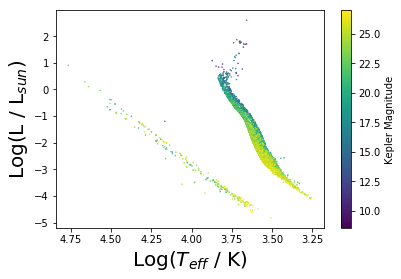

In [76]:
scatter(starfield['logTe'], starfield[u'logL'],marker='.',
     c = starfield[u'Kepler_mag'],s=1)
gca().invert_xaxis()
colorbar(label="Kepler Magnitude")
xlabel("Log($T_{eff}$ / K)", fontsize=20)
ylabel("Log(L / L$_{sun}$)", fontsize=20)

# So, what we see here is the HR diagram for the simulated star field. 

# more details on how simulation is run:
#  http://stev.oapd.inaf.it/~webmaster/trilegal_1.6/help.html

[Tim - add info about how you get RA/DEC?]

`popset.h5` contains the simulated populations, and can be loaded as follows:

In [ ]:
from vespa import PopulationSet
popset = PopulationSet.load_hdf('TestCase1/popset.h5')

Individual populations can be accessed from this object as follows:

In [ ]:
bebs = popset['beb']
hebs = popset['heb']

Each of these population objects has a `.stars` attribute that contains all of the data for all the simulated instances of that model.

As before, `*.png` files are diagnostic figures.  `FPPsummary.png` displays the summary of the results, and the others are informative visualizations of the various models, showing the distribution of simulated trapezoidal model parameters compared to the trapezoidal fit to the true transit candidate signal.

You can also directly load the `FPPCalculation` object from this directory:

In [ ]:
from vespa import FPPCalculation
fpp = FPPCalculation.load('TestCase1')

At this point, you should be able to quickly get the false positive probability result:


In [ ]:
fpp.FPP()

The  is quick this time because the populations are already generated, and the likelihood computations have been cached.

## Appendix 1: Detrending a light curve 
As noted above, VESPA requires a detrended, flatened, phase-folded lightcurve to work. [As described here](https://github.com/barentsen/kepler-athenaeum-tutorial/blob/master/how-to-find-a-planet-tutorial.ipynb), the process of finding a planet requires several steps before you get to the point where you have a phase-folded, flattened light curve (like the kind you need for VESPA). Let's try the steps [from this tutorial](https://github.com/barentsen/kepler-athenaeum-tutorial/blob/master/how-to-find-a-planet-tutorial.ipynb) and flatten a light curve.

First, let's take a sample light curve from the K2 mission. Let's try the one at [this URL](https://www.cfa.harvard.edu/~avanderb/k2c14/ep248463350.html), EPIC 248463350. 

The ExoFop page for this source is [at this link](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=248463350). 

Save the files you will need on this target (or a different one, if you repeat the process) to your Data directory, and let's plot it and see what it looks like:


Populating the interactive namespace from numpy and matplotlib


Text(0.5,0,u'Time')

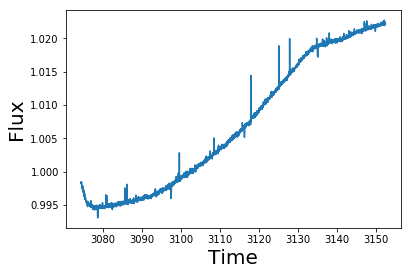

In [10]:
%pylab inline
import pandas as pd
epic_target = pd.read_csv("Data/raw248463350.txt", skiprows=1,names=['time','flux', 'error'])
errorbar(epic_target['time'], epic_target['flux'],epic_target['error'])
ylabel("Flux", fontsize=20)
xlabel("Time", fontsize=20)


This light curve has long term trends (what could those be due to?). For finding planets, they are not very helpful. So, we will use a low pass filter to remove them:

Text(0.5,0,u'Time')

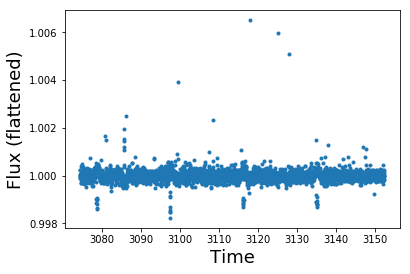

In [60]:
import scipy.signal
trend = scipy.signal.savgol_filter(epic_target['flux'], 101, polyorder=3) 
epic_target['corr_flux'] = (epic_target['flux'] / trend)

plot(epic_target['time'], epic_target['corr_flux'], '.')
ylabel("Flux (flattened)", fontsize=18)
xlabel("Time", fontsize=18)

You will notice that this low pass filter is not perfect, but it has turned the messy light curve into a flattened curve with a few events that look like transits. At this point, we need to figure out the periods of the planets, so we know which periods to fold over to generate the `transit.ini` files for VESPA.

In [ ]:
## parameters from Andrew's fit:
# P=18.788228,E=2457930.470510
# P=6.393653,E=2457941.008880
# and Rp/R*1 = 0.036485216
# Rp/R*2 = 0.017301727

In [21]:
periods = [6.393653, 18.788228]
tcent = [2457941.008880,2457930.470510]
rp_rs = [0.017301727,0.036485216]
headings = ['Time', 'Relative Flux', 'Flattened Relative Flux', 'Flattened Relative Flux with planet 2 removed',
           'Flattened Relative Flux with planet 1 removed']
import pandas as pd
epic_target_fitted = pd.read_csv("Data/processed248463350.csv", delimiter=",", skiprows=1,names = headings,engine='python',index_col = None)


Now, we can try plotting the modded curves for planet(s) in the system. We will 

Text(0.5,0,u'Time')

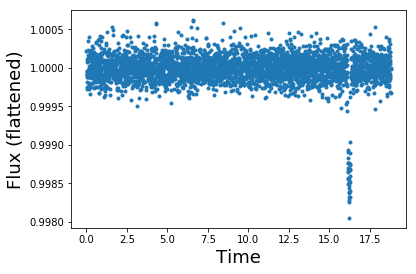

In [22]:
plot(epic_target_fitted['Time'].values % periods[1], epic_target_fitted['Flattened Relative Flux with planet 2 removed'].values, '.')
ylabel("Flux (flattened)", fontsize=18)
xlabel("Time", fontsize=18)

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
epic_target_fitted

,Time,Relative Flux,Flattened Relative Flux,Flattened Relative Flux with planet 2 removed,Flattened Relative Flux with planet 1 removed
0,3074.4246,0.998227,0.999956,0.999956,0.999956
1,3074.4450,0.998237,1.000000,1.000000,1.000000
2,3074.4654,0.998129,0.999926,0.999926,0.999926
3,3074.4859,0.998416,1.000250,1.000250,1.000250
4,3074.5063,0.998158,1.000029,1.000029,1.000029
5,3074.5267,0.998278,1.000187,1.000187,1.000187
6,3074.5472,0.998085,1.000034,1.000034,1.000034
7,3074.5676,0.998021,1.000010,1.000010,1.000010
8,3074.5880,0.997864,0.999894,0.999894,0.999894
9,3074.6085,0.997912,0.999985,0.999985,0.999985
